<a href="https://colab.research.google.com/github/Geek-a-Byte/Privacy-Preserving-Federated-Learning-Aided-Cervical-Cancer-Classification/blob/main/pre-defence/FL_Cervical_Cancer_1st_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies and Required Imports

In [ ]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall Pillow

In [ ]:
# install the new one
!pip install Pillow==5.3.0

In [ ]:
# import the new one
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [ ]:
# since the input images are quite large, we will disable the size check
PIL.Image.MAX_IMAGE_PIXELS = None

In [ ]:
!pip install torchvision
!pip install torch

In [ ]:
!pip uninstall syft
!pip install syft==0.2.9

In [ ]:
# Imports here
import cv2
import shutil 
import os
import time
from collections import OrderedDict
from datetime import datetime
from pytz import timezone  
import copy

import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Loading and Formatting the dataset

In [ ]:
!unzip "/content/drive/MyDrive/Cervical Cancer.zip" -d "./CervicalCancer/"

In [ ]:
# Function for Formatting Dataset
def FormatDataset(dataset_src, dataset_dest, classes):
    # Making a Copy of Dataset
    new_cropped_dest = [os.path.join(dataset_dest, cls, 'CROPPED') for cls in classes];
    new_complete_dest = [os.path.join(dataset_dest, cls, 'COMPLETE') for cls in classes];
    cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls + "/CROPPED" for cls in classes ];
    complete_src = [ dataset_src + "/im_" + cls + "/im_" + cls for cls in classes ];
    for (dest1, dest2) in zip(new_cropped_dest, new_complete_dest):
        os.makedirs(dest1);
        os.makedirs(dest2);
    # Formating Cropped Images
    for (src,new_dest) in zip(cropped_src, new_cropped_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (64, 64));
                img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);
    # Formatting Complete Images
    for (src,new_dest) in zip(complete_src, new_complete_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (256, 256));
                img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);
                
# Source Location for Dataset
src = '/content/CervicalCancer';
# Destination Location for Dataset
dest = './CervicalCancerDataset';
# Image Classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"];
# Formatting Dataset
FormatDataset(src, dest, classes);

In [ ]:
root_dir = "./CervicalCancerDataset"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

def GetDatasetSize(path, classes, main = "CROPPED"):
    num_of_image = {}
    for cls in classes:
        # Counting the Number of Files in the Folder
        num_of_image[cls] = len(os.listdir(os.path.join(path, cls, main)));
    return num_of_image;

print(GetDatasetSize(root_dir, classes, "COMPLETE"));

{'Dyskeratotic': 223, 'Koilocytotic': 238, 'Metaplastic': 271, 'Parabasal': 108, 'Superficial-Intermediate': 126}


## Splitting the dataset into train,test,validation

In [ ]:
# Function for Creating Train / Validation / Test folders (One time use Only)

def TrainValTestSplit(root_dir, classes_dir, main = "CROPPED", val_ratio = 0.15, test_ratio = 0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('CervicalCancerSplitDataset/train/' + cls)
        os.makedirs('CervicalCancerSplitDataset/valid/' + cls)
        os.makedirs('CervicalCancerSplitDataset/test/' + cls)

        # Folder to copy images from
        src = os.path.join(root_dir, cls, main);

        # Spliting the Files in the Given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls,':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'CervicalCancerSplitDataset/train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'CervicalCancerSplitDataset/valid/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'CervicalCancerSplitDataset/test/' + cls)
        print();
        

# Preforming Train / Validation / Test Split
root_dir = "./CervicalCancerDataset"               # Dataset Root Folder
classes_dir = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]   # Classes
TrainValTestSplit(root_dir, classes_dir);

## Creating Dataloaders

We first load the data and transform the training Dataset into a Federated Dataset to send the worker clients. This federated dataset is now given to a Federated DataLoader which will iterate over remote batches.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(), # randomly flip and rotate
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = '/content/CervicalCancerSplitDataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("selected: ", device)

selected:  cpu


In [ ]:
# set timezone
my_timezone = timezone('Asia/Dhaka')

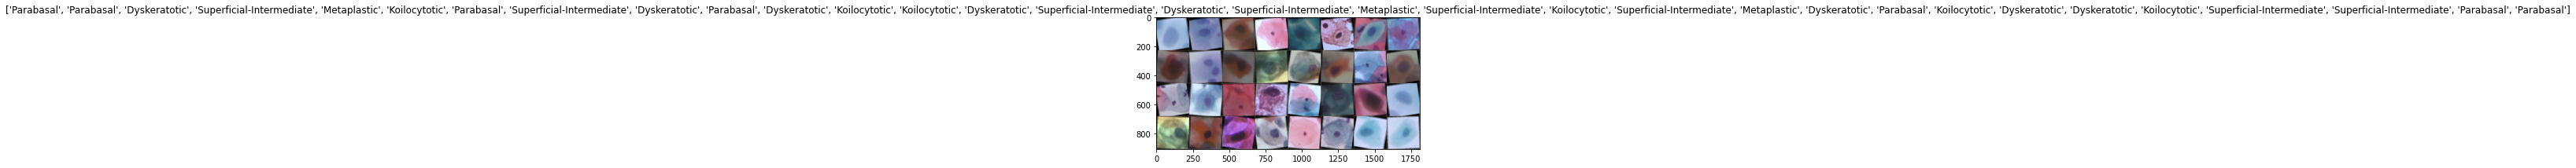

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Building and training the classifier

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{} at {}'.format(epoch, num_epochs - 1, datetime.now(my_timezone).strftime('%I:%M:%S %p (%d %b %Y)')))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# super simplified
model = models.densenet121(pretrained=True)

for param in model.parameters():
  param.requires_grad = True

model.classifier = nn.Linear(1024, 5)
model = model.to(device)

In [ ]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## non_federated_cervical_cancer_cnn model training

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

## Save the non_federated_cervical_cancer_cnn model training model

In [ ]:
torch.save(model.state_dict(), "non_federated_cervical_cancer_cnn.pt")

## Federated Learning Initial Setup

In [ ]:
import syft as sy
hook = sy.TorchHook(torch)

In [ ]:
hospital_1 = sy.VirtualWorker(hook, id="hospital_1")
hospital_2 = sy.VirtualWorker(hook, id="hospital_2")

In [ ]:
class Arguments():
    def __init__(self):
        self.batch_size = 32
        self.test_batch_size = 32
        self.epochs = 4
        self.lr = 0.006
        self.momentum = 0.9
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 10
        self.save_model = False

args = Arguments()
torch.manual_seed(args.seed)

In [ ]:
train_data = image_datasets['train']
train_data.data = train_data.imgs

In [ ]:
federated_train_loader = sy.FederatedDataLoader(train_data.federate((hospital_1, hospital_2)), batch_size=args.batch_size, shuffle=True)

In [ ]:
dataloaders['train'] = federated_train_loader

## Federated Training

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4 at 06:26:33 AM (22 Sep 2022)
----------
train Loss: 0.5121 Acc: 0.8178
valid Loss: 0.5840 Acc: 0.8503
Epoch 1/4 at 07:02:06 AM (22 Sep 2022)
----------
train Loss: 0.2293 Acc: 0.9244
valid Loss: 0.2321 Acc: 0.9260
Epoch 2/4 at 07:36:11 AM (22 Sep 2022)
----------
train Loss: 0.1487 Acc: 0.9488
valid Loss: 0.2026 Acc: 0.9276
Epoch 3/4 at 08:09:19 AM (22 Sep 2022)
----------
train Loss: 0.1195 Acc: 0.9580
valid Loss: 0.1776 Acc: 0.9391
Epoch 4/4 at 08:42:35 AM (22 Sep 2022)
----------
train Loss: 0.0970 Acc: 0.9675
valid Loss: 0.1803 Acc: 0.9342
Training complete in 169m 10s
Best val Acc: 0.939145


## Save the federated_cervical_cancer_cnn model training model

In [ ]:
torch.save(model.state_dict(), "federated_cervical_cancer_cnn.pt")